# Probabilistic Methods (Discrete)

## Exercise
Save this work in your anomaly-detection-exercises repository in a file named discrete_anomaly_detection.ipynb.

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

## Imports

In [1]:
#do the data things!
import numpy as np
import pandas as pd

#visualize
import matplotlib.pyplot as plt
import seaborn as sns

#my sql creds
import env

# import text and create_engine from sqlalchemy
from sqlalchemy import text, create_engine

In [2]:
# create url (same way as before)
url = env.get_db_url('logs')

<div class="alert alert-block alert-info">
<b>NOTE: </b> 
    
`pd.read_sql` operates differently in the newest update
    
New process: 
1. import `text` and `create_engine` from `sqlalchemy`
2. create url (same way as before)
3. create engine with url and connect
4. specify query as text
5. send query and engine into `pd.read_sql`
    
</div>

In [3]:
# create engine with url and connect
# conn = create_engine(url).connect()

#specify query as text
# query = text('show tables')

# send query and connection into pd.read_sql
# pd.read_sql(query, conn)

# pd.read_sql('show tables', url)

#### get data

In [4]:
df = pd.read_sql('select * from api_access', url)

### Prepare

the data needs to be parsed out so we can see each piece of the access log

In [5]:
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [6]:
# function to deal with parsing one entry in our log data
#this function works on one string
def parse_log_entry(entry):
    """
    This function to deal with parsing one entry in our log data
    This function works on one string
    """
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    output['timestamp'] = pd.to_datetime( output['timestamp'])
    return pd.Series(output)

In [7]:
parse_log_entry(df.entry[0])

ip                          97.105.19.58
timestamp            2019-04-16 19:34:42
request_method                       GET
request_path       /api/v1/sales?page=81
http_version                    HTTP/1.1
status_code                          200
size                              512495
user_agent        python-requests/2.21.0
dtype: object

In [8]:
#apply string function to every element in a series
df = df.entry.apply(parse_log_entry)
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ip              13974 non-null  object        
 1   timestamp       13974 non-null  datetime64[ns]
 2   request_method  13974 non-null  object        
 3   request_path    13974 non-null  object        
 4   http_version    13974 non-null  object        
 5   status_code     13974 non-null  object        
 6   size            13974 non-null  int64         
 7   user_agent      13974 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 873.5+ KB


### For the sake of lesson, adding some anomalies

In [10]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", 
     '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", 
     '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

In [11]:
df = pd.concat([df,new])

In [12]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13973,97.105.19.58,2019-04-17 12:55:14,GET,/api/v1/sales?page=71,HTTP/1.1,200,510166,python-requests/2.21.0
0,95.31.18.119,21/Apr/2019 10:02:41,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0
1,95.31.16.121,17/Apr/2019 19:36:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,1005,python-requests/2.21.0
2,97.105.15.120,18/Apr/2019 19:42:41,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0


In [13]:
df = df.reset_index(drop=True)

In [14]:
df.timestamp = df.timestamp.astype('datetime64')

In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y/%m/%d')

In [16]:
df.timestamp.dtype

dtype('<M8[ns]')

#### making new size column based mb

In [17]:
#divide by 1024 twice
df['size_mb'] = df['size'] / 1024 / 1024

In [18]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


## Detecting Anomalies in Discrete Variables

- count
- frequency
- visualize
- conditional probability

###  count

let's see how many times each ip address comes up in our dataset

In [19]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.90.165.200         1
95.31.16.121          1
95.31.18.119          1
45.23.250.16          1
52.91.30.150          1
34.207.64.242         1
3.88.129.158          1
54.172.14.223         1
3.92.201.136          1
35.174.209.2          1
54.145.52.184         1
34.229.70.250         1
97.105.15.120         1
Name: ip, dtype: int64

In [20]:
#save it into a dataframe
ip_df1 = df.ip.value_counts().reset_index().rename(columns={'index':'ip','ip':'cnt'})
ip_df1.head()

,ip,cnt
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21
5,24.26.242.9,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.90.165.200,1


### frequency

let's now calculate the probabity for each ip 

ip_prob = count for each ip / total count in the dataframe

In [21]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,size_mb
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [22]:
#best function
df.ip.value_counts(normalize=True)

97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
24.26.242.9       0.001502
35.175.171.137    0.000143
52.87.230.102     0.000143
70.121.214.34     0.000143
52.90.165.200     0.000072
95.31.16.121      0.000072
95.31.18.119      0.000072
45.23.250.16      0.000072
52.91.30.150      0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
54.172.14.223     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
54.145.52.184     0.000072
34.229.70.250     0.000072
97.105.15.120     0.000072
Name: ip, dtype: float64

In [23]:
#save it to a df
ip_df2 = df.ip.value_counts(normalize=True).reset_index().rename(columns={'index':'ip','ip':'percent'})
ip_df2.head()

,ip,percent
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,68.201.219.223,0.001502


#### merge em

In [24]:
ip_df = pd.merge(ip_df1, ip_df2, how='inner', on='ip')
ip_df.head()

,ip,cnt,percent
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,68.201.219.223,21,0.001502


### visualize them

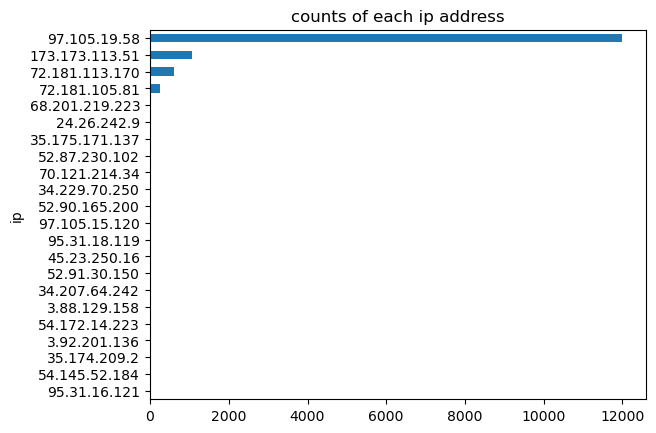

In [25]:
ip_df.set_index('ip').cnt.sort_values().plot.barh()
plt.title('counts of each ip address')
plt.show()

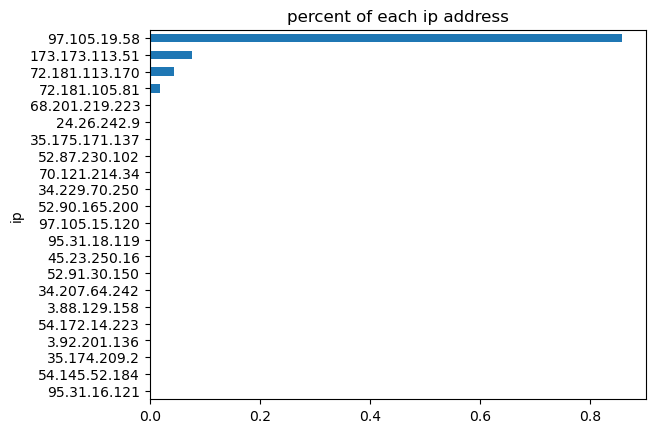

In [26]:
ip_df.set_index('ip').percent.sort_values().plot.barh()

plt.title('percent of each ip address')
plt.show()

### conditional probability

what is the probability of event A happening given that event B has happened? 

$P(A|B) = {P(A \cap B) \over P(B)}$

aka: the probability of both event A and event B happening divided by the probability of only B happening

# Excercises

In [10]:
# Apply the parse_log_entry function to each entry in the logs
df = df.entry.apply(parse_log_entry)

In [11]:
# Display the parsed logs
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [17]:
# Define a function to calculate count
def count(df, column):
    return df[column].value_counts()

In [19]:
count(df,'ip')

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [21]:
# Define a function to calculate frequency
def frequency(df, column):
    return df[column].value_counts(normalize=True)

In [22]:
frequency(df, 'ip')

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
68.201.219.223    0.001503
70.121.214.34     0.000143
52.87.230.102     0.000143
35.175.171.137    0.000143
54.145.52.184     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
34.229.70.250     0.000072
54.172.14.223     0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
52.91.30.150      0.000072
52.90.165.200     0.000072
45.23.250.16      0.000072
Name: ip, dtype: float64

In [27]:
# Define a function to visualize count
def visualize_count(df, column):
    df[column].value_counts().sort_values().plot(kind='barh')

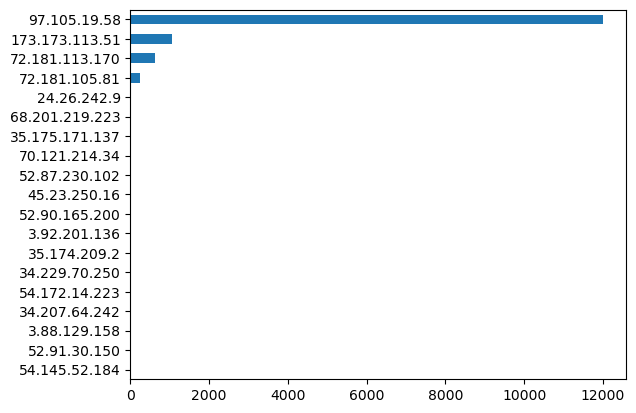

In [28]:
visualize_count(df, 'ip')

In [30]:
# Calculate the count and percent for each IP
ip_count_df = df['ip'].value_counts().reset_index().rename(columns={'index': 'ip', 'ip': 'count'})
ip_count_df['percent'] = (ip_count_df['count'] / df.shape[0]) * 100
ip_count_df.head()

,ip,count,percent
0,97.105.19.58,11998,85.859453
1,173.173.113.51,1059,7.578360
2,72.181.113.170,613,4.386718
3,72.181.105.81,246,1.760412
4,24.26.242.9,21,0.150279


In [31]:
# Define a function to visualize count
def visualize_percent(df, column):
    ip_count_df.set_index(column).percent.sort_values().plot.barh()

    plt.title('percent of each ip address')
    plt.show()

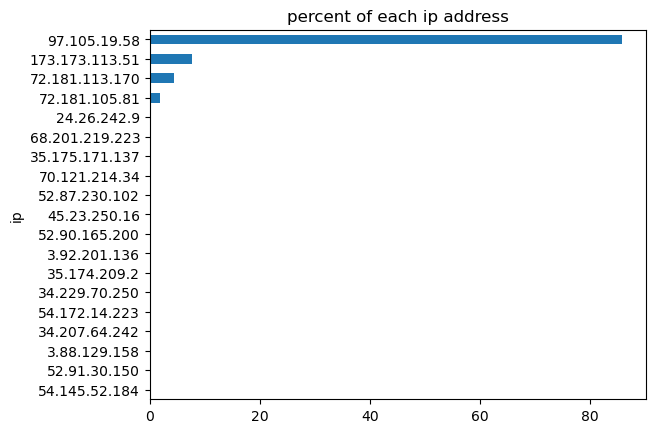

In [32]:
visualize_percent(df, 'ip')

In [42]:
# Define a function to calculate conditional probability
def conditional_probability(df, column_A, column_B):
    """
    This function calculates the conditional probability of a certain status code given a particular IP.
    It returns a DataFrame with the IP, status code, and calculated probability.
    """
    # Given a particular ip, what is probability of a certain status code
    status_given_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('prob').reset_index()
    # Cases where the probability is < 100% -- this means that multiple different status codes were encountered from the given ip address
    status_given_ip = status_given_ip[status_given_ip.prob < 1]
    return status_given_ip

In [45]:
conditional_probability(df, 'ip', 'timestamp')

,ip,timestamp,prob
0,173.173.113.51,2019-04-17 03:26:28,0.002833
1,173.173.113.51,2019-04-17 04:35:29,0.002833
2,173.173.113.51,2019-04-17 04:45:15,0.002833
3,173.173.113.51,2019-04-17 04:46:09,0.002833
4,173.173.113.51,2019-04-17 04:52:46,0.002833
...,...,...,...
10038,97.105.19.58,2019-04-17 12:55:00,0.000083
10039,97.105.19.58,2019-04-17 12:55:01,0.000083
10040,97.105.19.58,2019-04-17 12:55:04,0.000083
10041,97.105.19.58,2019-04-17 12:55:08,0.000083


In [44]:
def conditional_probability(df, column_A, column_B):
    """
    This function calculates the conditional probability of a certain value in column_B given a particular value in column_A.
    It returns a DataFrame with the values of column_A, column_B, and calculated probability.
    """
    # Given a particular value in column_A, what is probability of a certain value in column_B
    prob_given_A = df.groupby(column_A)[column_B].value_counts(normalize=True).rename('prob').reset_index()
    # Cases where the probability is < 100% -- this means that multiple different values in column_B were encountered from the given value in column_A
    prob_given_A = prob_given_A[prob_given_A.prob < 1]
    return prob_given_A

# Loop through every column combination
for column_A in df.columns:
    for column_B in df.columns:
        if column_A != column_B:
            print(f'Conditional probability of {column_B} given {column_A}:')
            print(conditional_probability(df, column_A, column_B))

Conditional probability of timestamp given ip:
                   ip           timestamp      prob
0      173.173.113.51 2019-04-17 03:26:28  0.002833
1      173.173.113.51 2019-04-17 04:35:29  0.002833
2      173.173.113.51 2019-04-17 04:45:15  0.002833
3      173.173.113.51 2019-04-17 04:46:09  0.002833
4      173.173.113.51 2019-04-17 04:52:46  0.002833
...               ...                 ...       ...
10038    97.105.19.58 2019-04-17 12:55:00  0.000083
10039    97.105.19.58 2019-04-17 12:55:01  0.000083
10040    97.105.19.58 2019-04-17 12:55:04  0.000083
10041    97.105.19.58 2019-04-17 12:55:08  0.000083
10042    97.105.19.58 2019-04-17 12:55:14  0.000083

[10032 rows x 3 columns]
Conditional probability of request_method given ip:
Empty DataFrame
Columns: [ip, request_method, prob]
Index: []
Conditional probability of request_path given ip:
                 ip                             request_path      prob
0    173.173.113.51                            /api/v1/items  0.0604